In [1]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['darkblue','forestgreen','darkorange','purple']
myFeatures = [['bias','delta stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
sns.set_context("talk")
colormap = ['rebeccapurple','teal','darkturquoise','springgreen']

# Sigma 1D Analysis 

In [2]:
# read from cluster array in order to get parallelizations
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 4 

initParam = 'all' # initializing for best GLM-HMM fit from all animals or subject-specific one
D = 4 # number of features
sessStop = -1 # last session to use in fitting

testLlAll = np.empty((4,len(subjectsWitten),len(sigmaList)))
bestTestLl = np.zeros((4,11))

for idx in range(0,3):
    subject = subjectsWitten[idx]
    testLl = []
    allP = [] 
    allW = [] 
    trainSessInd = []
    avgTestLl = []
    for K in [1,2,3,4]:
        for fold in range(0, fitFolds):
            testLl.append(np.load(f'../data_IBL/data_IBL_Cluster/{subject}/testLl_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
            allP.append(np.load(f'../data_IBL/data_IBL_Cluster/{subject}/P_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
            allW.append(np.load(f'../data_IBL/data_IBL_Cluster/{subject}/W_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
            trainSessInd.append(np.load(f'../data_IBL/data_IBL_Cluster/{subject}/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        avgTestLl.append(np.mean(testLl[:],axis=0))
    avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1

    for K in [1,2,3,4]:
        testLlAll[K-1][idx] = avgTestLl[K-1]

    bestSigmaInd = 7 # Choosing best sigma index across animals
    for K in [1,2,3,4]:
        bestTestLl[K-1][idx] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta

    # # Plotting each fold indiviudally for per-animal plots
    # fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    # fig.suptitle(f'{subject}')
    # for K in range(1,5):
    #     for fold in range(0, fitFolds):
    #         plot_testLl_CV_sigma(testLl[fitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)
    
    # # Plotting delta test ll averaged across folds for per-animal plots
    # fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    # fig.suptitle(f'{subject} Cross Validated')
    # fig.tight_layout()
    # for K in range(1,5):
    #     plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
    # axes.set_ylabel("Delta Test Ll (per trial)")


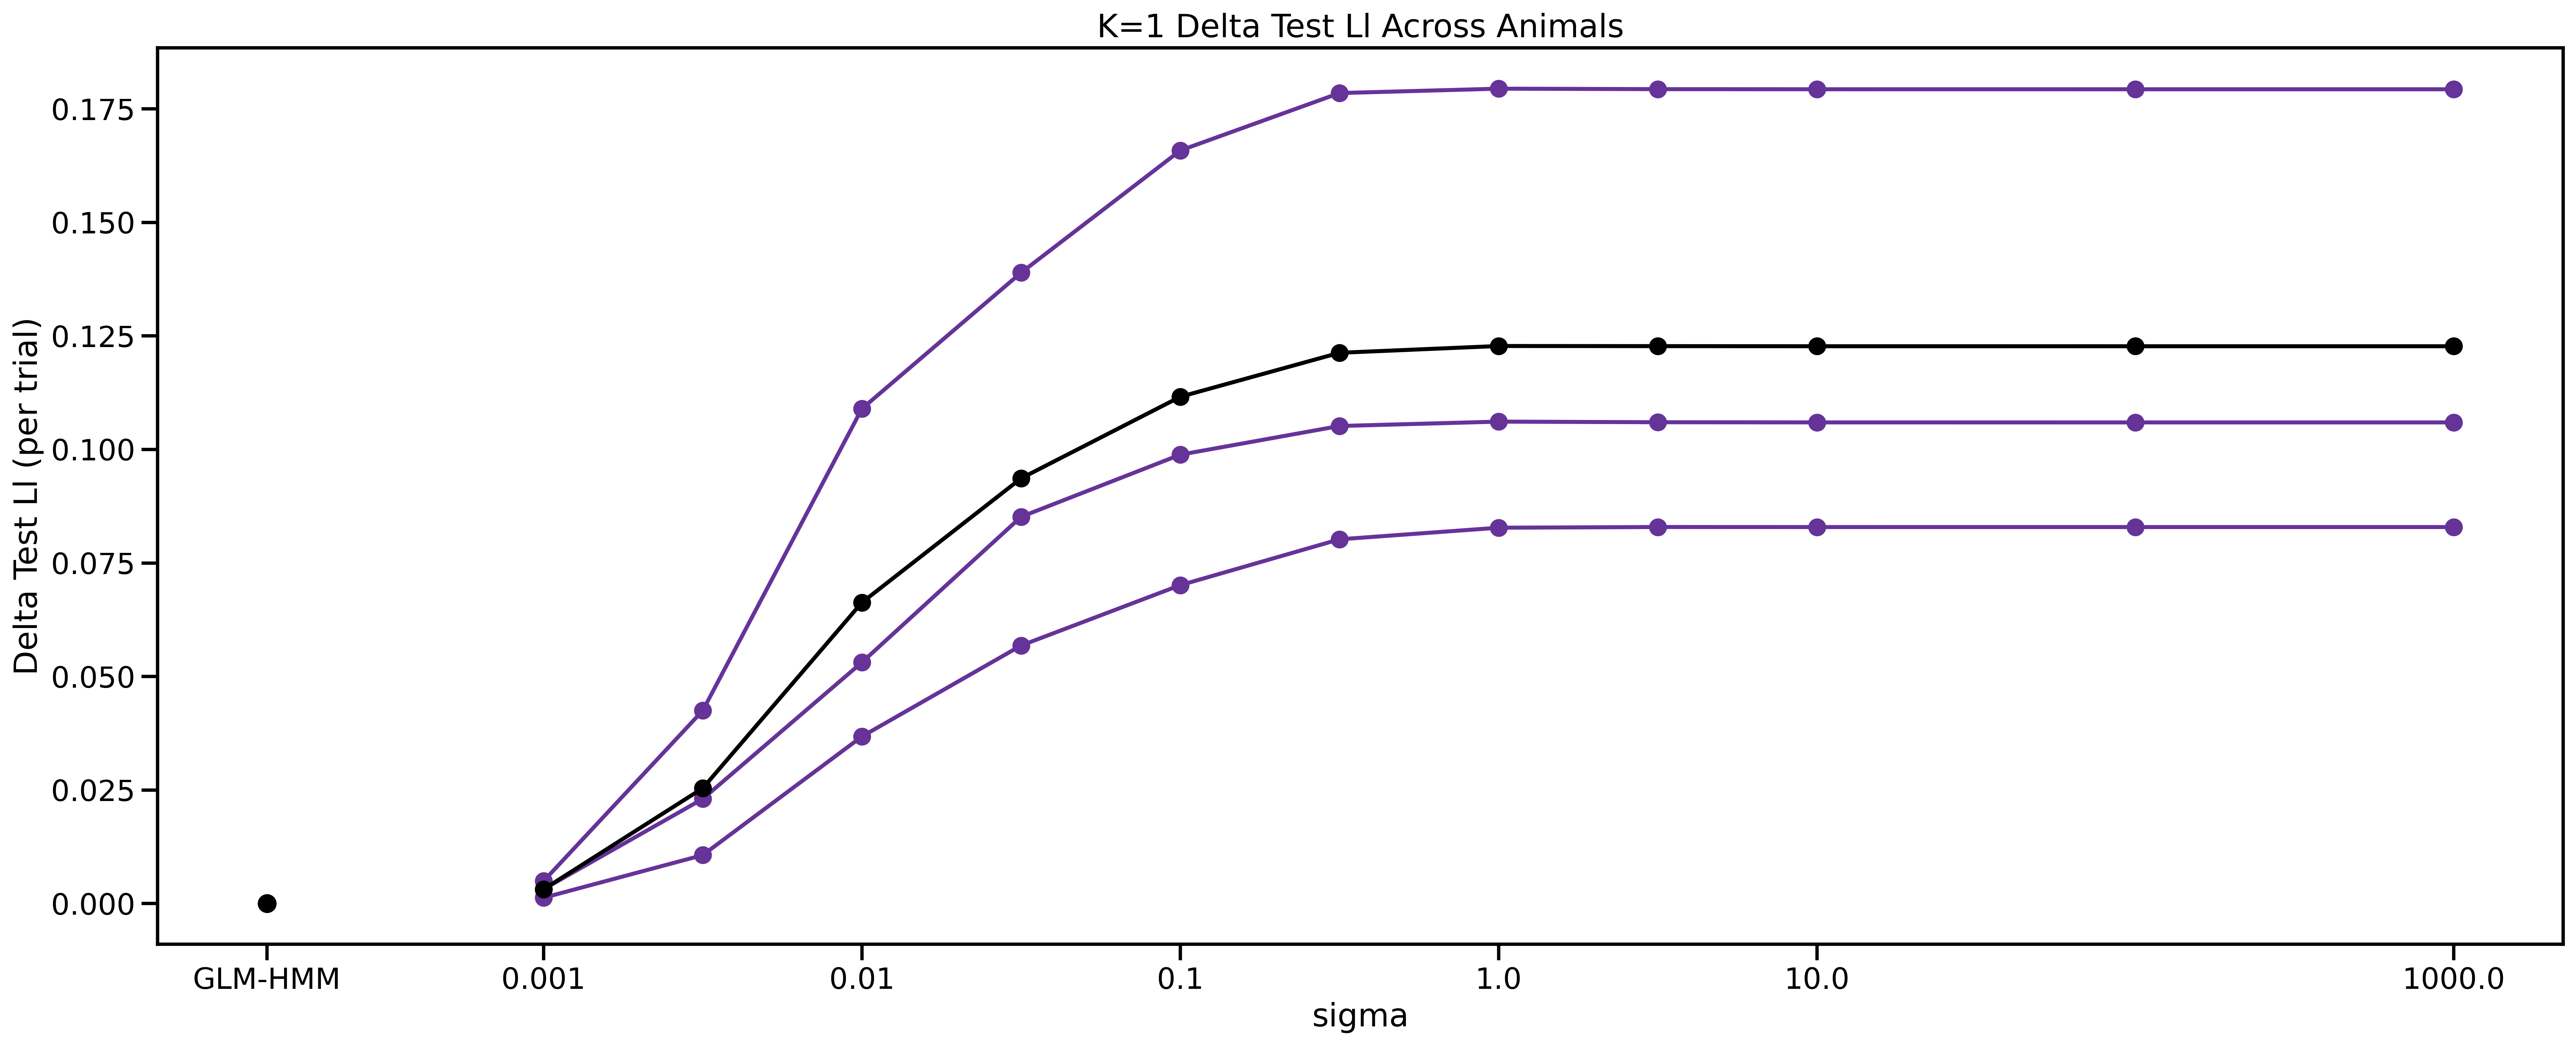

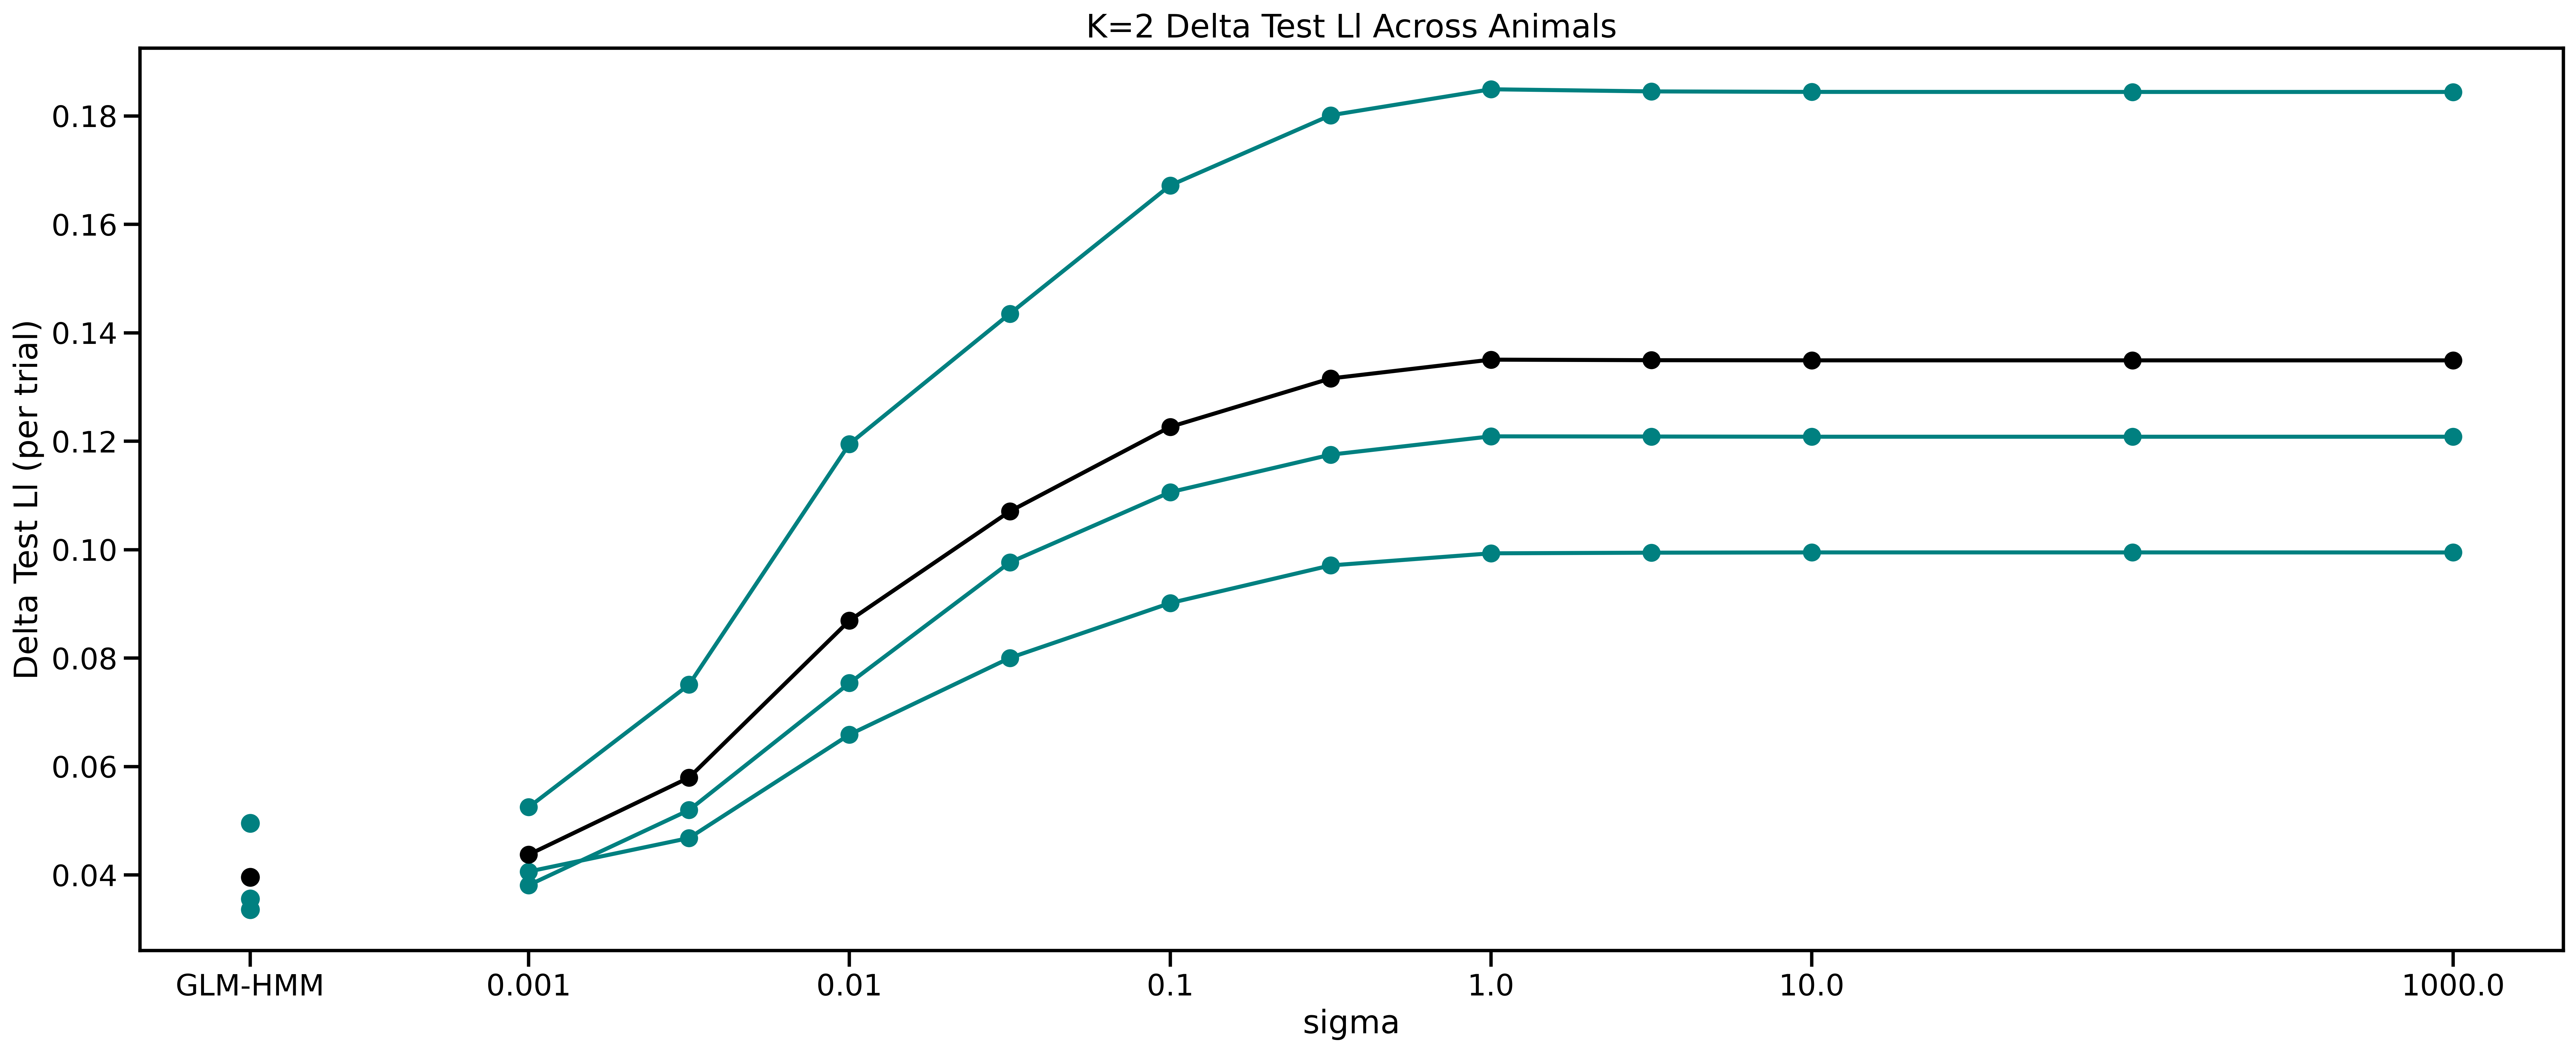

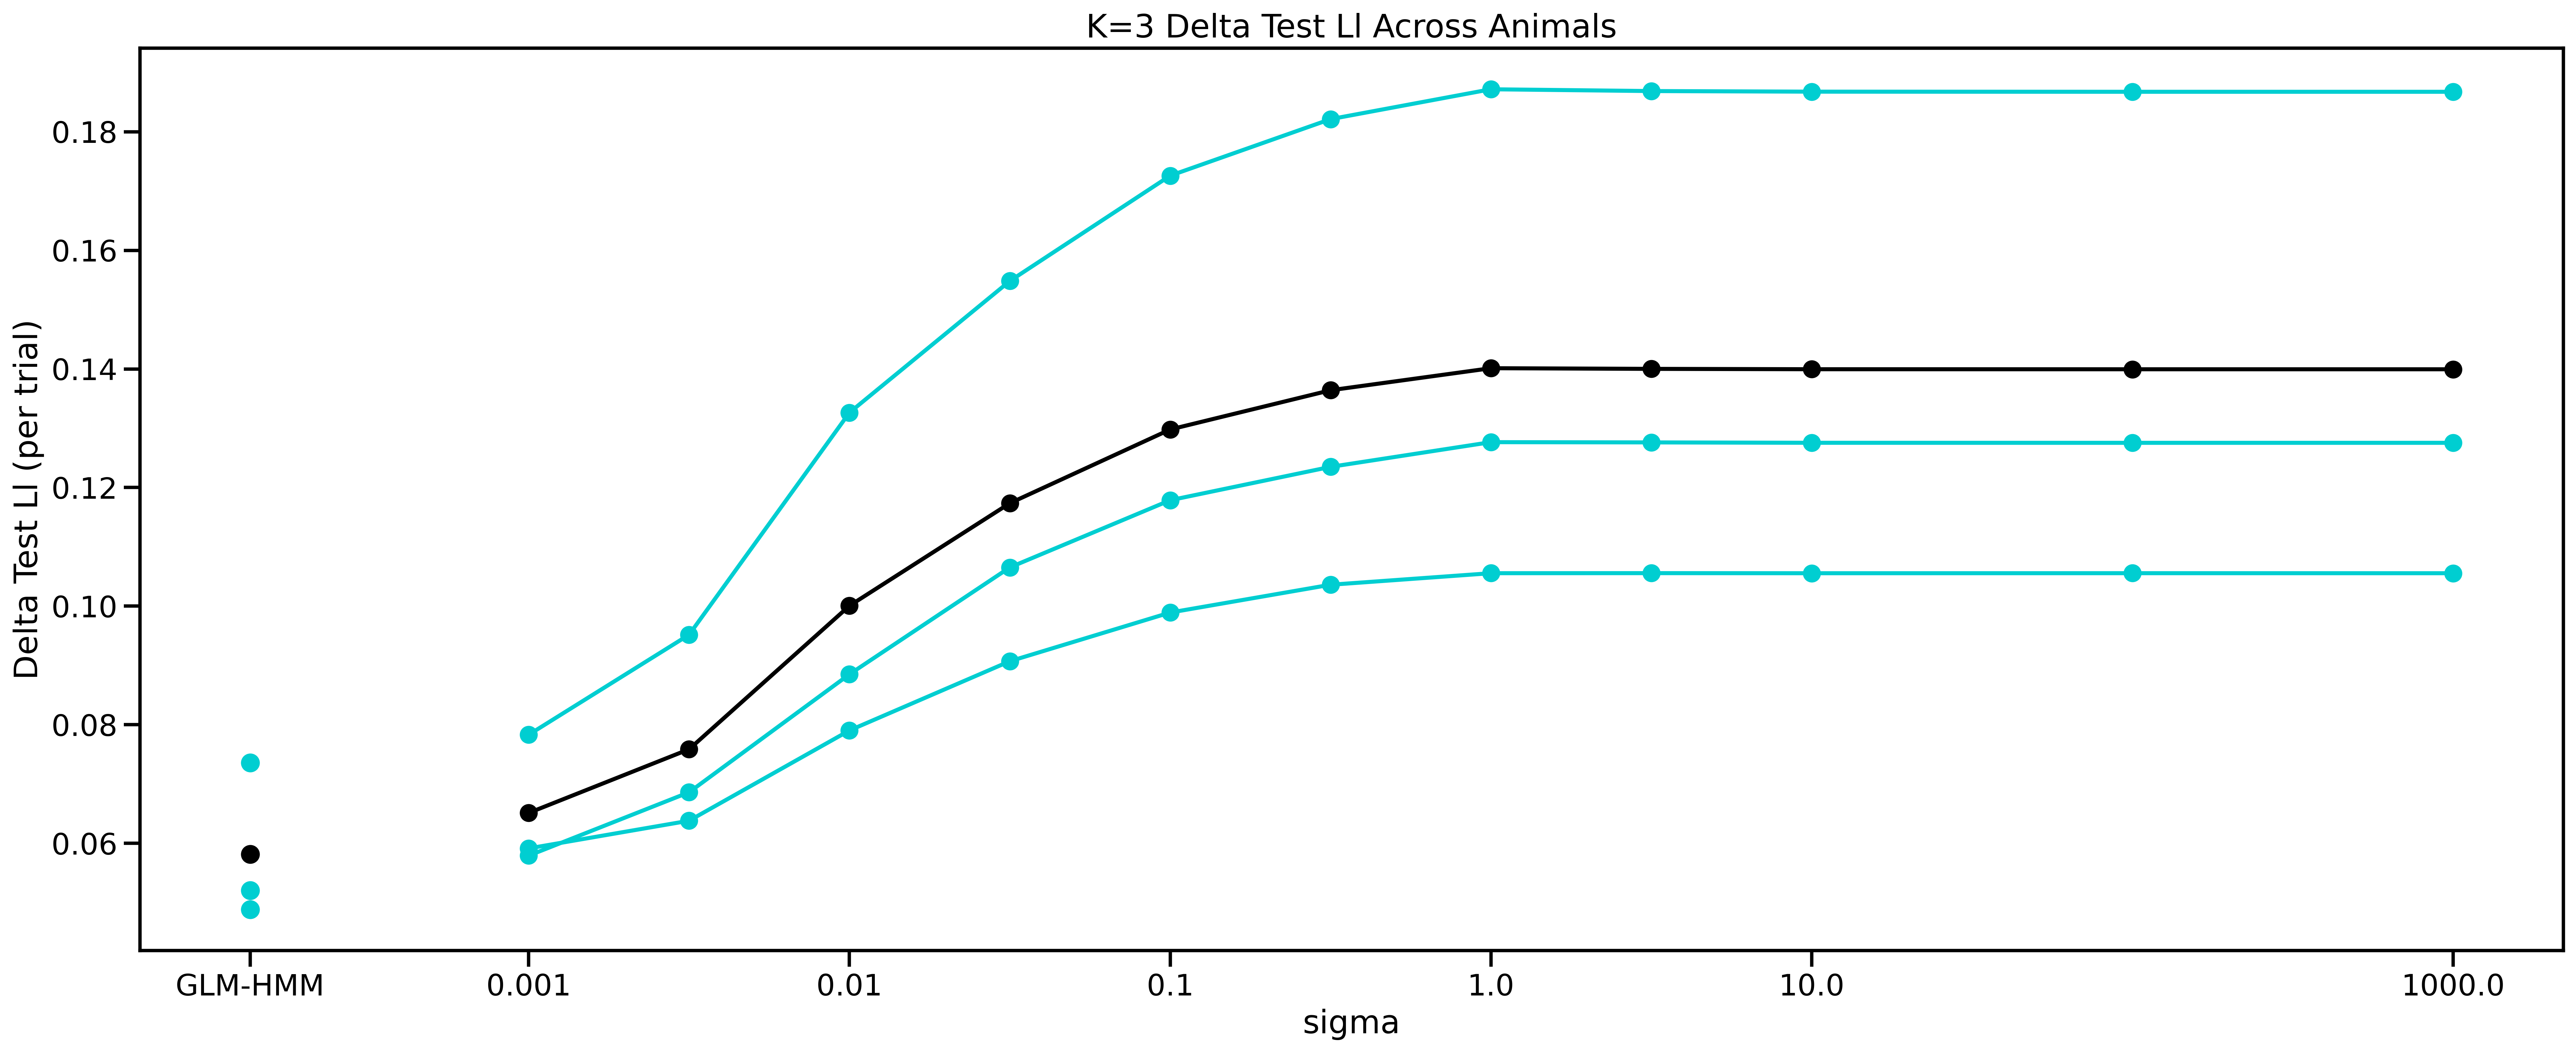

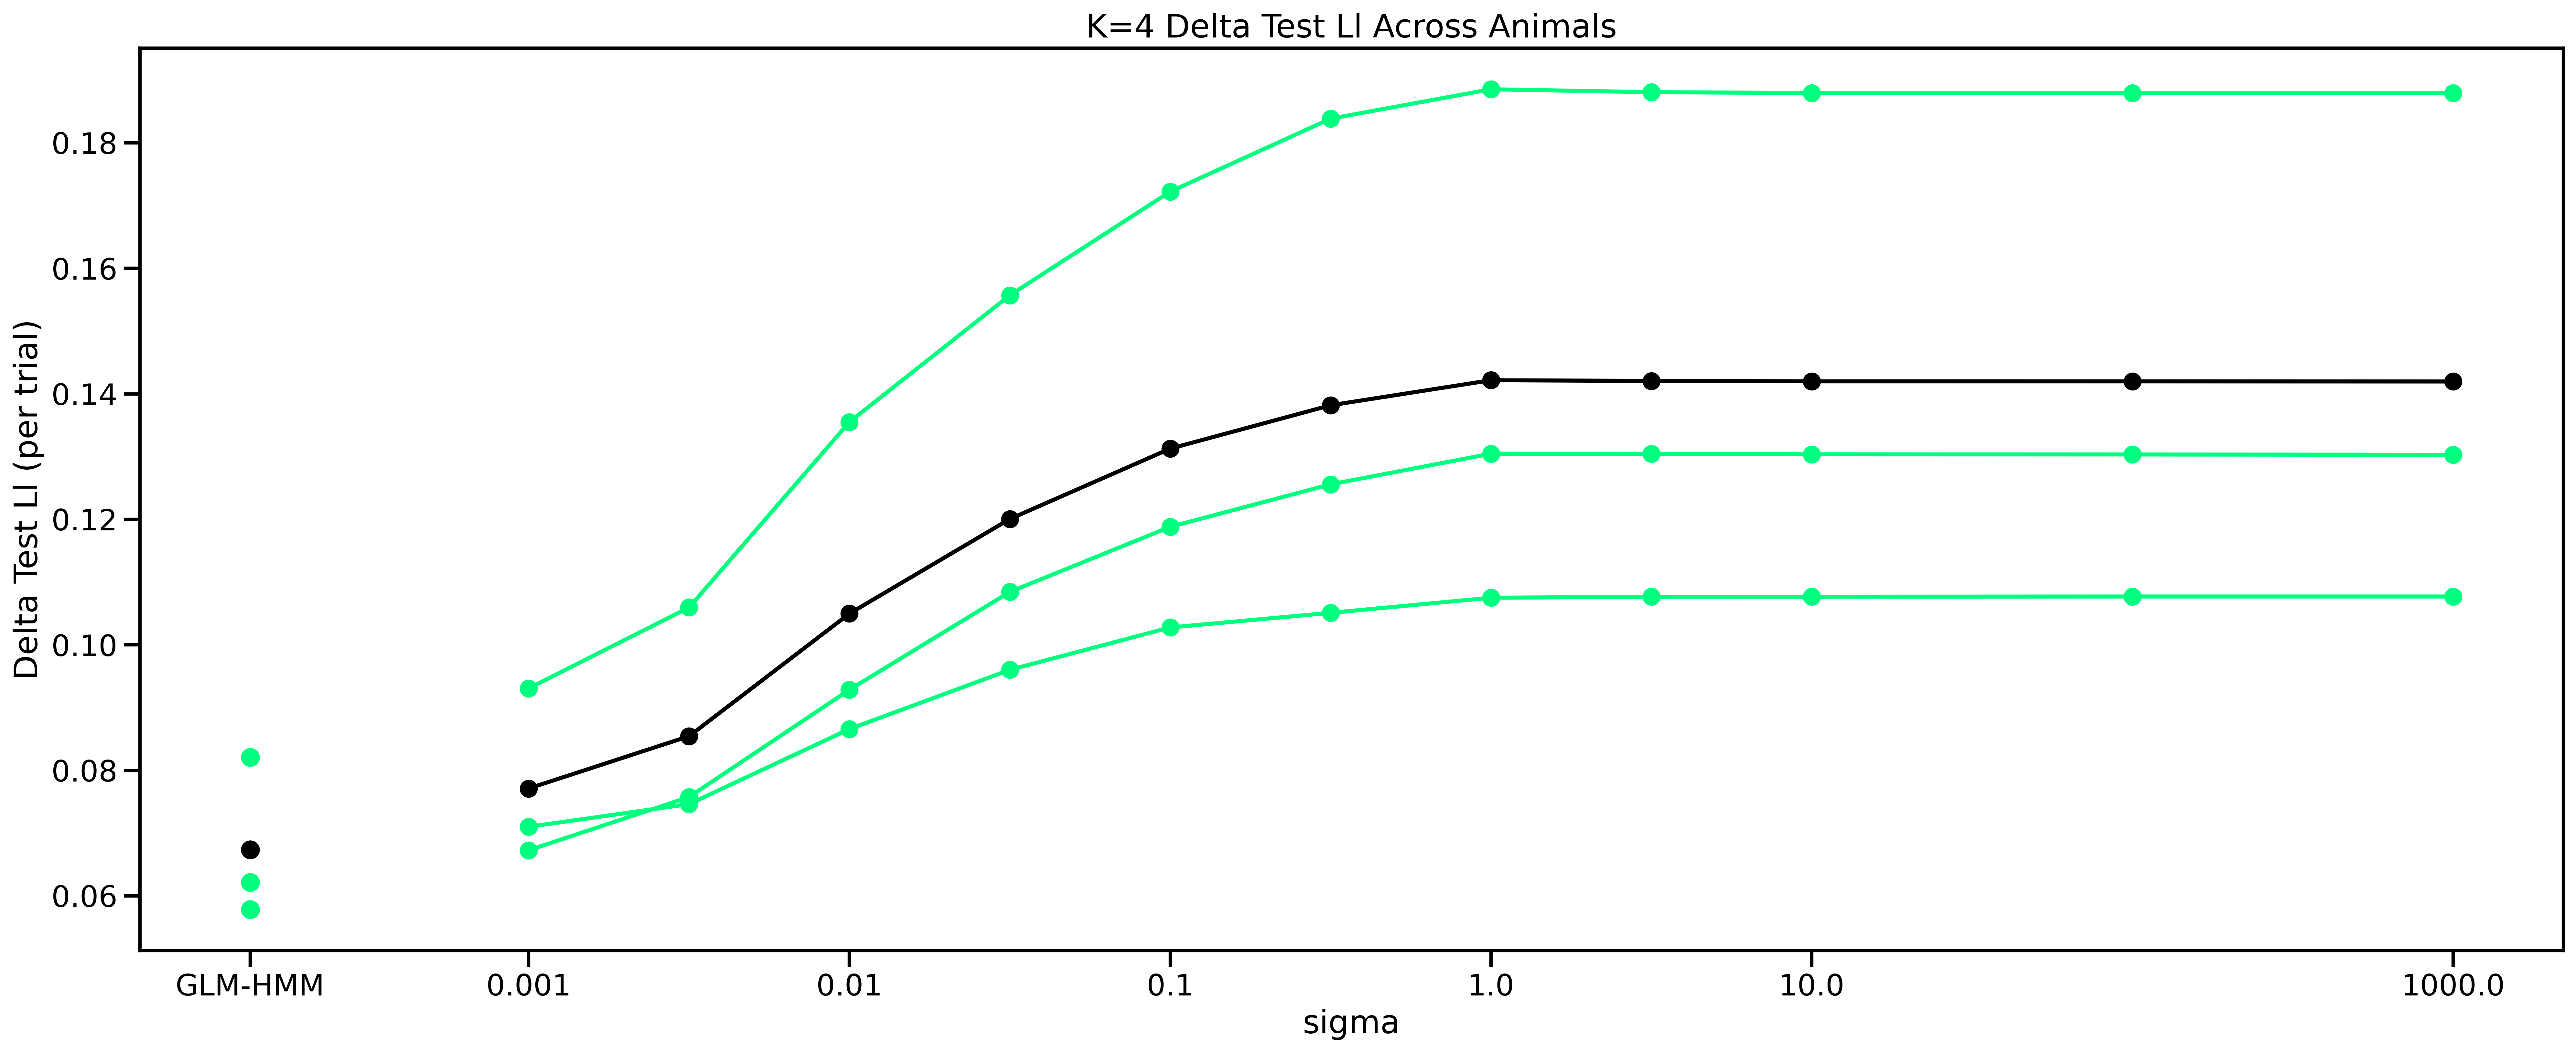

In [4]:
# Plotting one plot with all animals
for K in range(1,5):
    fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    fig.tight_layout()
    axes.set_title(f'K={K} Delta Test Ll Across Animals')
    for idx in range(0,3):
        subject = subjectsWitten[idx]
        plot_testLl_CV_sigma(testLlAll[K-1][idx], sigmaList=sigmaList, label=None, color=colormap[K-1], axes=axes)
    plot_testLl_CV_sigma(np.mean(testLlAll[K-1][0:3], axis=0), sigmaList=sigmaList, label=None, color='black', axes=axes)
    axes.set_ylabel("Delta Test Ll (per trial)")
    

Text(11.25, 0.5, 'Delta Test Ll (per trial)')

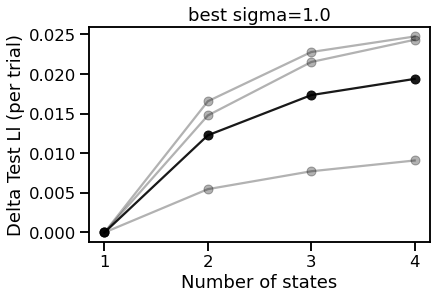

In [5]:
fig, axes = plt.subplots(1,figsize=(6,4))
fig.tight_layout()
for idx in range(0,3):
    axes.plot([1,2,3,4],bestTestLl[:,idx],'-o', color='black',alpha=0.3)
    axes.set_xticks([1,2,3,4])
axes.plot([1,2,3,4], np.mean(bestTestLl[:,0:3], axis=1), '-o', color='black',alpha=0.9)
axes.set_title(f'best sigma={np.round(sigmaList[bestSigmaInd],2)}')
axes.set_xlabel('Number of states')
axes.set_ylabel('Delta Test Ll (per trial)')


Text(11.25, 0.5, '% test accuracy')

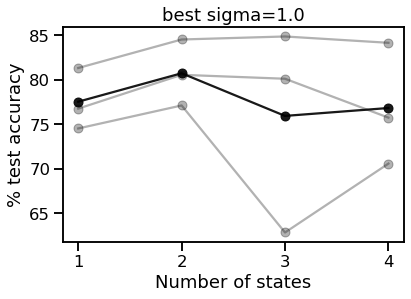

In [10]:
bestSigmaInd = 7 # Sigma to look at parameterss for
accuracy = np.zeros((len(subjectsWitten), 4))
fig, axes = plt.subplots(1,figsize=(6,4))
fig.tight_layout()
for idx in range(0,3):
    subject = subjectsWitten[idx]
    x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
    trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=4, blocks=10, random_state=1)
    for K in [1,2,3,4]:
        acc = np.empty((fitFolds))
        for fold in range(0, fitFolds):
            allP = np.load(f'../data_IBL/data_IBL_Cluster/{subject}/P_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy')
            allW = np.load(f'../data_IBL/data_IBL_Cluster/{subject}/W_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy')
            trainSessInd = np.load(f'../data_IBL/data_IBL_Cluster/{subject}/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy')
            testSessInd = np.load(f'../data_IBL/data_IBL_Cluster/{subject}/testSessInd_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy')
            dGLM_HMM = dglm_hmm1.dGLM_HMM1(testX[fold].shape[0],K,4,2)
            _, acc[fold] = dGLM_HMM.get_test_accuracy(testX[fold], testY[fold], list(testSessInd), allP[bestSigmaInd], reshapeWeights(allW[bestSigmaInd], trainSessInd, testSessInd), pi0=None)
        accuracy[idx, K-1] = np.mean(acc)

    axes.plot([1,2,3,4], accuracy[idx,:], '-o', color='black',alpha=0.3)
axes.plot([1,2,3,4], np.mean(accuracy[0:3,:], axis=0), '-o', color='black',alpha=0.9)
axes.set_title(f'best sigma={np.round(sigmaList[bestSigmaInd],2)}')
axes.set_xlabel('Number of states')
axes.set_ylabel('% test accuracy')

# Sigma 2D Analysis 

In [15]:
print(testLl[4:9,4:9])
print(np.argmin(testLl))

[[-0.54193766 -0.53254165 -0.5312854  -0.5311841  -0.56840576]
 [-0.53958902 -0.53027353 -0.52897951 -0.52886277 -0.56569299]
 [-0.53980503 -0.53041666 -0.52906683 -0.52893893 -0.56578454]
 [-0.53994307 -0.53053895 -0.52917738 -0.52904694 -0.56592677]
 [-0.55761007 -0.54846267 -0.5491594  -0.55097047 -0.60017757]]
0


In [16]:
df = pd.DataFrame(columns=['subject','K']) # in total z=0,43
z = 0
for subject in subjectsWitten:
    for K in [1,2,3,4]:
        df.loc[z, 'subject'] = subject
        df.loc[z, 'K'] = K
        z += 1

# read from cluster array in order to get parallelizations
idx = 0
subject = df.loc[idx,'subject']
K = df.loc[idx,'K']

# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 4 

initParam = 'all' # initializing for best GLM-HMM fit from all animals or subject-specific one
D = 4 # number of features
sessStop = -1 # last session to use in fitting

In [19]:
testLl = np.load(f'../data_IBL/data_IBL_Cluster/{subject}/testLl_{subject}_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy')

In [20]:
print(testLl.shape)

(12,)
